In [ ]:
import os
import kagglehub
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report, confusion_matrix
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from torch.optim import AdamW
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
path = kagglehub.dataset_download("kazanova/sentiment140")
print("Path to dataset files:", path)

df = pd.read_csv(
    r"C:\Users\egor1\.cache\kagglehub\datasets\kazanova\sentiment140\versions\2\training.1600000.processed.noemoticon.csv",
    encoding='latin-1',
    names=["target","ids","date","flag","user","text"]
)

Path to dataset files: C:\Users\egor1\.cache\kagglehub\datasets\kazanova\sentiment140\versions\2


In [ ]:
df.sample(10)

,target,ids,date,flag,user,text
1583880,4,2190489620,Tue Jun 16 02:52:46 PDT 2009,NO_QUERY,Nateprime,Brooke im glad you better i miss you!
763432,0,2298320760,Tue Jun 23 11:31:51 PDT 2009,NO_QUERY,miilene,going to the dmv
1223548,4,1990423771,Mon Jun 01 04:50:02 PDT 2009,NO_QUERY,sarafahey,"@jacvanek You're gorgeous, and insanely awesome."
1487562,4,2068313109,Sun Jun 07 13:52:12 PDT 2009,NO_QUERY,taylorxjane,Out on a walk with the family
424823,0,2063189635,Sun Jun 07 01:41:44 PDT 2009,NO_QUERY,pinkpoopp,@thrila yeppe/.i hope i could share to you the...
1474682,4,2065768326,Sun Jun 07 09:15:07 PDT 2009,NO_QUERY,TheStarr,On my way http://twitpic.com/6u2ld
285673,0,1993673485,Mon Jun 01 10:45:12 PDT 2009,NO_QUERY,itsdaveywhite,Dentists once again said my teeth aren't bad e...
732448,0,2264071745,Sun Jun 21 02:41:28 PDT 2009,NO_QUERY,AppleTreeThief,my timetable sucks - I have two humanities my...
1111066,4,1972162595,Sat May 30 08:41:18 PDT 2009,NO_QUERY,BurningAngel21,"I'm a voodoo child of the Goddess, slightly re..."
485160,0,2181042012,Mon Jun 15 11:17:15 PDT 2009,NO_QUERY,Trannyyy,5 5 5 more dayssss! I miss home


In [ ]:
df.isna().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [ ]:
df["target"].value_counts()

#классы сбалансированны

target
0    800000
4    800000
Name: count, dtype: int64

In [ ]:
df['target'] = df['target'].replace(4, 1)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"].tolist(), df["target"].tolist(), test_size=0.2, random_state=42
)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_texts(texts, labels, max_length=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

train_input_ids, train_attention_masks, train_labels = tokenize_texts(train_texts, train_labels)
val_input_ids, val_attention_masks, val_labels = tokenize_texts(val_texts, val_labels)

In [ ]:
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)

batch_size = 16
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}'):
        batch = tuple(t.to(device) for t in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }

        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f'Average training loss: {avg_train_loss}')

Epoch 1:   0%|          | 0/80000 [00:00<?, ?it/s]c:\Users\egor1\VScodeProjects\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 1: 100%|██████████| 80000/80000 [7:27:49<00:00,  2.98it/s]       


Average training loss: 0.3310743887219578


Epoch 2: 100%|██████████| 80000/80000 [6:03:10<00:00,  3.67it/s]    


Average training loss: 0.27864313631565313


Epoch 3: 100%|██████████| 80000/80000 [5:59:14<00:00,  3.71it/s]  

Average training loss: 0.23907276033764938


In [ ]:
#сохраняем модель и состояние оптимизатора
output_dir = "./saved_model/"
os.makedirs(output_dir, exist_ok=True)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

checkpoint = {
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_train_loss,
}
torch.save(checkpoint, os.path.join(output_dir, "checkpoint.pt"))

In [ ]:
#загружаем обученную модель

output_dir = "./saved_model/"
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

checkpoint = torch.load(os.path.join(output_dir, "checkpoint.pt"))
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
def evaluate_model(val_dataloader, class_names=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_predictions = []
    all_labels = []
    all_logits = []
    all_texts = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_logits.append(logits.cpu())

            if 'texts' in batch:
                all_texts.extend(batch['texts'])

    all_logits = torch.cat(all_logits, dim=0)

    # cчитаем accuracy (классы сбалансированны), precision, recallm f1
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average="weighted")

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=class_names if class_names is not None else None))

    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    errors = []
    if all_texts:
        for i, (text, true_label, pred_label) in enumerate(zip(all_texts, all_labels, all_predictions)):
            if true_label != pred_label:
                errors.append({
                    "text": text,
                    "true_label": true_label,
                    "predicted_label": pred_label,
                    "probabilities": torch.softmax(all_logits[i], dim=0).numpy()
                })

    errors_df = pd.DataFrame(errors) if errors else pd.DataFrame()

    # топ-5 текстов с наибольшей уверенностью в ошибке
    if not errors_df.empty:
        errors_df['confidence'] = errors_df.apply(lambda x: x['probabilities'][x['predicted_label']], axis=1)
        print("\nTop 5 errors with highest confidence:")
        print(errors_df.sort_values('confidence', ascending=False).head(5))

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "errors": errors_df
    }

c:\Users\egor1\VScodeProjects\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Accuracy: 0.8696
Precision: 0.8696
Recall: 0.8696
F1 Score: 0.8696

Classification Report:
              precision    recall  f1-score   support

    Positive       0.87      0.87      0.87    159494
    Negative       0.87      0.87      0.87    160506

    accuracy                           0.87    320000
   macro avg       0.87      0.87      0.87    320000
weighted avg       0.87      0.87      0.87    320000



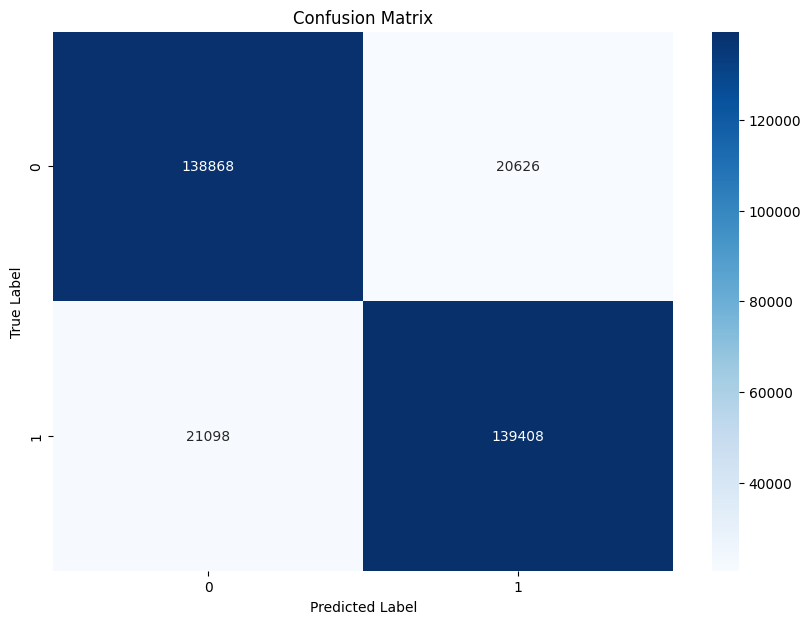

{'accuracy': 0.8696125, 'precision': 0.8696169329868643, 'recall': 0.8696125, 'f1': 0.8696128245435609, 'errors': Empty DataFrame
Columns: []
Index: []}


In [ ]:
result = evaluate_model(val_dataloader, class_names=["Positive", "Negative"])

Совпадение метрик (accuracy = precision = recall = F1) обусловлено симметричностью confusion matrix и идеальным балансом классов в валидационной выборке, что приводит к равенству TP/(TP+FP) (precision) и TP/(TP+FN) (recall) при равных значениях FP и FN.

In [ ]:
def predict_sentiment(text):
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    prediction = torch.argmax(outputs.logits, dim=1).item()
    return "Positive" if prediction == 1 else "Negative"

In [ ]:
sample_text = "I love this movie. Its fantastic"
print(f"Sample text: '{sample_text}'")
print(f"Predicted sentiment: {predict_sentiment(sample_text)}")

Sample text: 'I love this movie. Its fantastic '
Predicted sentiment: Positive


In [ ]:
sample_text = "I like this movie so much that I'm ready to gouge out my eyes so I never have to see it again. " # Мне нравится этот фильм настолько, что я готов выколоть свои глаза, чтобы никогда его не видеть
print(f"Sample text: '{sample_text}'")
print(f"Predicted sentiment: {predict_sentiment(sample_text)}")

Sample text: 'I like this movie so much that I'm ready to gouge out my eyes so I never have to see it again. '
Predicted sentiment: Positive


Очевидно, что модель не понимает сарказма, это проблема, но хотя бы распознаёт негативные/позитивные слова